Hunter S. DiCicco

with Dr. Dongwon Lee, Ph.D.

# Multinomial SVC for Categories of News

## Diagnostics to Assess Model Performance

## TODO:
* Refactor base modules [FIRST PRIORITY]
* Rectify Promotional Content/Native Ads Class Balance
* Prepare Pipeline description for misreporting
* ✓ Restructure repo to put URLs in the data dir and stop tracking checkpoints and caches
* [Browser Extension Tutorial](https://www.smashingmagazine.com/2017/04/browser-extension-edge-chrome-firefox-opera-brave-vivaldi/)

### Setup and Imports

In [1]:
cd ..

C:\Users\hunter\dev\sysfake


In [7]:
import warnings
import pickle
import glob
import copy
import pdb
import sys
import os

from itertools import combinations
from functools import partial

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import normalize
#from sklearn.feature_selection import RFECV

from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import numpy as np

from validator import validate
def main():
    """
    Instead of an import, we wrap the execution of both of these vital modules within `exec`.
    This ensures that changes are enacted on every chunk evaluation.
    """
    exec(open("classifier.py").read(), globals())
    exec(open("validator.py").read(), globals())

main()
random_state = 4261998

Retrieving data...
Retrieving data...
Retrieving data...
Retrieving data...
------------
recall:[0.7  0.88 0.03 0.29 0.89]
precision:[0.82 0.84 0.54 0.23 0.51]
f1:[0.75 0.86 0.06 0.26 0.65]
------------

{1: 68, 2: 28, 3: 217, 5: 158, 7: 24}
This model got 55.8% correct || 625 out of 1120.
False negatives for ./data/real data (1)
{5: 55, 2: 13}
False negatives for ./data/fake data (2)
{5: 28}
False negatives for ./data/opinion data (3)
{5: 144, 2: 8, 1: 12, 7: 53}
False negatives for ./data/polarized data (5)
{7: 139, 3: 4, 2: 15}
False negatives for ./data/satire data (7)
{1: 22, 3: 2}


### Helper Functions

In [8]:
CLASS_DICT = dict(zip(('real', 'fake', 'opinion', 'polarized', 'satire', 'promotional', 'correction'),
                      (1, 2, 3, 5, 7, 9, 11)))

def load_latest_model(substr='', verbose=0):
    """
    Loads and returns the latest `pickle` from the `models` directory with the user-specified substring in its name.
    If no file is found, produce a warning for `verbose>0` and then return none.
    """
    # obtain a glob of the files in the `models` directory
    list_of_files = glob.glob(f"models/*{substr}*.pickle")

    # obtain the most recently created model with `substr` in its name
    # will warn if verbose, and then return none if no file is found
    try:
        latest_model = max(list_of_files, key=os.path.getctime)
        # open the most recent model and load it into the namespace
        # WARNING: only load pickle files that you trust!
        with open(latest_model, mode="rb") as filein:
            model = pickle.load(filein)
    except ValueError:
        if verbose>0:
            warnings.warn(f"No most-recent file{' containing ' if substr else '.'}\"{substr}\"", UserWarning)
        return None

    return model

def cross_val_best(x, y, kf=None, kernel='rbf'):
    global random_state

    kf = kf if kf else KFold(n_splits=20, shuffle=True, random_state=random_state)
    splits = kf.split(x, y)

    models, recalls, precisions = {}, [], []

    ### report mean macro and micro average recall per fold
    for fold_i, (train, test) in enumerate(splits):
        x_train, y_train = x[train], y[train]
        x_test, y_test = x[test], y[test]
        model = SVC(C=2.075,
                    kernel=kernel,
                    gamma='scale',
                    break_ties=True,
                    random_state=random_state).fit(x_train, y_train)
        y_pred = model.predict(x_test)
        score = recall_score(y_test, y_pred, average='micro')
        #print(f"Per-class precision: {', '.join(list(map(str, precision_score(y_test, y_pred, average=None))))}")
        recalls.append(recall_score(y_test, y_pred, average=None))
        precisions.append(precision_score(y_test, y_pred, average=None))
        models.update({model:score})
        validate(model, x_test, y_test);

    best_model = max(models, key=models.get)
    recalls = pd.DataFrame(recalls, columns=list(CLASS_DICT.keys()))
    precisions = pd.DataFrame(precisions, columns=list(CLASS_DICT.keys()))

    print(f"Mean Class Recall Across {kf.n_splits!s} Folds: {*recalls.mean().round(4),!s}")
    print(f"Mean Class Precision Across {kf.n_splits!s} Folds: {*precisions.mean().round(4),!s}")
    return best_model

def search(x, y, kernel='rbf', verbose=0, cv=3, refit=False, scoring='f1_micro', p=False):
    global random_state
    svc = SVC(kernel=kernel, class_weight='balanced', probability=p, break_ties=False)
    params = {'C': sp.stats.distributions.arcsine(scale=1e4),
              'gamma':sp.stats.distributions.expon(scale=10)}
    clf = RandomizedSearchCV(estimator=svc,
                             refit=refit,
                             cv=cv,
                             param_distributions=params,
                             scoring=scoring,
                             n_jobs=-1, verbose=verbose)
    clf.fit(x, y)
    return clf

### Data Read

In the following chunk we use `glob` to iterate over the files containing `ArticleVector`s, and call `pd.read_csv` on each one.

The returned `pd.DataFrame` is stored in a dictionary under its respective filename.

In [9]:
use_dummies = False

# list of features in use
features = ["url_ending_index", "from_reputable_source_index",
            "today_index", "grammar_index", "quotation_index",
            "past_tense_index", "present_tense_index", "should_index",
            "opinion_index", "all_caps_index", "from_satire_source_index",
            "exclamation_index", "apa_index", "name_source_index",
            "interjection_index", "you_index", "dot_gov_ending_index",
            "from_unreputable_source_index", "label"]

data_with_vars = {}

read_with_params = partial(pd.read_csv,
                           delim_whitespace=True,
                           names=features)

for file in glob.glob('data\\*vectors*.txt'):
    data_with_vars[file.split('\\')[-1].split('.')[0]] = read_with_params(file)

for var, df in data_with_vars.items():
    df['label'] = CLASS_DICT[var.split('_')[0]]

d_full = pd.concat(data_with_vars.values(), ignore_index=True)

if use_dummies:
    dummy_labels = pd.get_dummies(d_full.label)
    dummy_labels.columns = list(CLASS_DICT.keys())
    d_full = d_full.drop('label', axis=1)
    d_full = pd.concat([d_full, dummy_labels], axis=1)

# cannot stress this enough: the data NEED to be normalized
# for both timely convergence and proper learning.
# somehow not all of the features are normalized.

if use_dummies:
    d_full[d_full.columns[:-7]] = normalize(d_full[d_full.columns[:-7]])
else:
    d_full[d_full.columns[:-1]] = normalize(d_full[d_full.columns[:-1]])

# eliminate duplicate rows
d_full = d_full[~d_full.duplicated()]

In [11]:
if use_dummies:
    x, y = d_full[d_full.columns[:-7]], d_full[d_full.columns[-7:]]
else:
    x, y = *(d_full.drop('label', axis=1),
             d_full['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

* Scoring metrics:
    * Weighted F1. [Why?](https://stackoverflow.com/a/33330487)
        * Because we care about the precision and recall of *all* classes, and F1 gives a good sense of both.
    * Weighted one vs. rest ROC-AUC (?)


* What are we searching over?
    * Kernel $[\text{Linear}, \text{RBF}]$
    * C (Hyperplane Regularization/Slack) $[0, 10000]$
        * [`scipy.stats.distributions.arcsine`](https://docs.scipy.org/doc/scipy/reference/_images/scipy-stats-arcsine-1.png)
        * Values just under `1e4` (almost hard-margin) are relevant, but so are values very close to 0 (extremely soft margin).
        * Anything between is also fair game (shift+scale can make this near-uniform at a certain probability).
    * $\gamma$ (Kernel coefficient for `rbf` models) $(0, 10]$
        * [`scipy.stats.distributions.expon`](https://docs.scipy.org/doc/scipy/reference/_images/scipy-stats-expon-1.png)
        * Influence of $\text{x}_i$ $\propto$ $\gamma^{-1}$
    * Break Ties $[True, False]$
        * Should we use the decision function to break ties when we find a point on a margin?
        * Expensive, but can be worth it. Depends most on dataset.

In [23]:
model = load_latest_model(substr='rscv')
if not model:
    grid = search(x, y,
                  kernel='linear',
                  scoring='precision_weighted',
                  refit=True,
                  p=False, verbose=3)

    if grid.refit:
        model = grid.best_estimator_
        with open("models/best-model-rscv-full_kernel-{kernel}_C-{C}_breakties-{break_ties}.pickle".format(**model.get_params()), mode='wb') as fileout:
            pickle.dump(model, fileout)

    results = pd.DataFrame(grid.cv_results_)
    results.to_csv(f"./figures/grid_full_{np.int(np.floor(grid.best_score_*100))!s}.csv")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:  2.4min remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


## Feature Selection

NOTES: *Some of the insights on linear feature importance used below obtained from [here](https://stackoverflow.com/a/22831491).*

*`plot_coefficients` method initially obtained from [here](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d)*

In the next chunk we will use our models' learned *support vectors* to perform feature selection.

Training a Support Vector machine involves building *separating hyperplanes* to differentiate data by label using the *one-vs.-rest (OVR)* strategy.

Namely, say we trained an SVM on data with three labels. During inference, the SVM classifies by checking what region the new example occupies and saying "Since it's in this region, it does not belong to class `one` nor does it belong to class `three`, so it must belong to class `two`." *One-Vs.-Rest* is an excellent strategy because weights are learned by abstracting a multinomial problem into several binary problems!

In the case of a C-Support Vector Machine (SVC), we use a parameter called `C` to allow for limited deviation from the hyperplane that we build.

This means that our hyperplanes are relaxed -- there is `C` leeway such that examples within `C` distance of the hyperplane can be assumed to belong to the other side. Generally, the larger `C` is, the more the error function will punish misclassifications -- as `C` tends to infinity the model acts like a hard margin model instead.

When we are done, each feature is assigned an associated *support vector*, which contains *weight coefficients*. These coefficients directly explain how much influence a feature has when our model performs inference.

The rows of the weight matrix describe the unique feature weights for each pair in the separation problems, which can be written as the mathematical combinations of each of the class labels with the others (`list(combinations(CLASS_DICT.values(), 2))`):

| hyperplane comparing | first class | second class |
|----------------------|-------------|--------------|
|weights for|1|2|
|weights for|1|3|
|...|
|weights for|1|11|
|weights for|2|3|
|weights for|2|4|
|...|
|weights for|2|11|
|...|
|weights for|7|11|
|weights for|9|11|

When we take the *vector norm* of each feature-weight vector, we get a sense (**not** a direct measurement) of feature variance when in the context of the other features in the training data. This is different from taking the feature-wise variance of the data, because this measurement speaks directly to the efficacy of a feature's variance for a specific separation problem.

One final area of examination would be the model's trained *dual coefficients*, which are out of the author's scope and would require further research.

[We may be able to use this to create a similar dual visualization.](https://cel.archives-ouvertes.fr/cel-01003007/file/Lecture2_Linear_SVM_Dual.pdf)

**In summary we should prune those features which have near-zero contribution according to the weights, as well as those that have very little overall feature-weight variance.**

Viewing the weight coefficients superimposed on each other in feature space as well as the overall feature-weight variances would give us a great idea as to which features contribute to which inference results. Let's build those visualizations now:

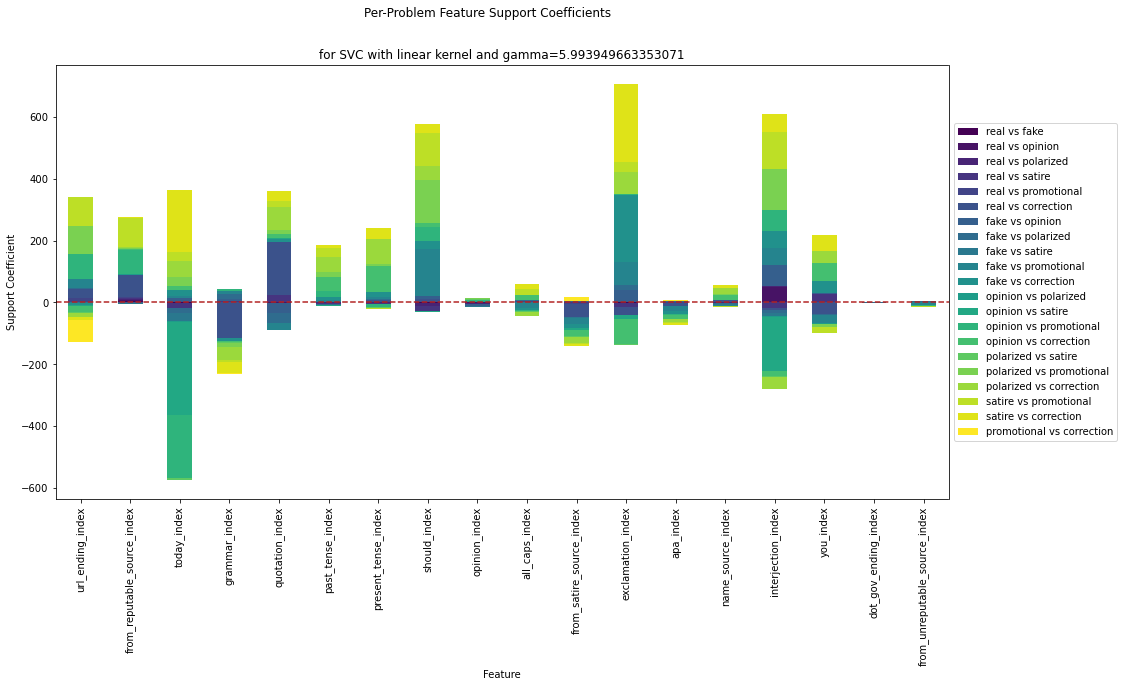

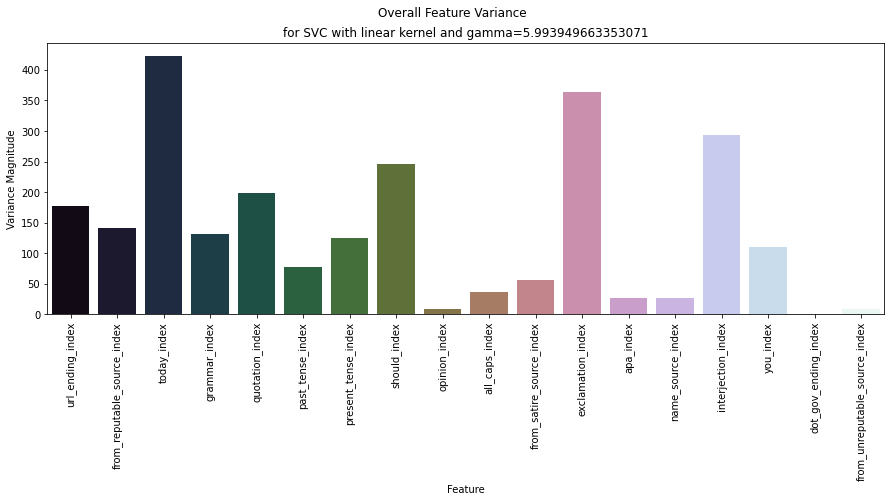

In [28]:
model = load_latest_model(substr='rscv*linear')

features = ["url_ending_index", "from_reputable_source_index",
            "today_index", "grammar_index", "quotation_index",
            "past_tense_index", "present_tense_index", "should_index",
            "opinion_index", "all_caps_index", "from_satire_source_index",
            "exclamation_index", "apa_index", "name_source_index",
            "interjection_index", "you_index", "dot_gov_ending_index",
            "from_unreputable_source_index"]

# we are only writing procedures for linear (done) and rbf (todo)
# linear has easy-to-interpret feature-weight calculations
# and rbf uses the dual coefficients, which are notoriously harder to interpret

def plot_coefficients(classifier, feature_names):
    """
    Method Docstring Placeholder
    """
    #pdb.set_trace()
    global CLASS_DICT

    # extract class labels and #classes
    classes = list(CLASS_DICT.keys())
    n_classes = len(classes)

    # use itertools.combinations to create a list
    # of the pair combinations of class labels
    classes = list(combinations(classes, 2))

    # coerce the weight coefficient matrix to a pandas dataframe
    # for utility
    if classifier.kernel=='linear':
        coef = pd.DataFrame(classifier.coef_, columns=feature_names)
    else: 
        coef = pd.DataFrame(classifier.support_vectors_, columns=feature_names)
    # we must transpose `coef` to plot it in feature space
    ax = coef.T.plot(kind="bar",
                     stacked=True,
                     figsize=(16,8),
                     colormap="viridis",
                     title=f"for SVC with {classifier.kernel} kernel and gamma={classifier.gamma!s}")

    # now we need a handle for the plot's legend
    # in order to correctly label the separation problems
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # the i'th patch label in the legend
    # should contain the items of the combination pairs
    for i, label in enumerate(legend.get_texts()):
        label.set_text(f"{classes[i][0]!s} vs {classes[i][1]!s}")

    # a line at the origin to create a visual anchor
    plt.axhline(linestyle='dashed', color='firebrick')

    # setting axis labels, over-title and saving the figure
    ax.set(xlabel="Feature", ylabel="Support Coefficient")
    plt.suptitle("Per-Problem Feature Support Coefficients")
    plt.savefig(f"./figures/{len(CLASS_DICT)!s}lab_featureselection_1.png")
    return coef

coef = plot_coefficients(model, features)

# obtain the number of classes
# as well as weights for supports of each class
(n_classes, coefs) = *(len(model.classes_), model.coef_.transpose()),

# take the vector norm ([x dot x]^(1/2)) of each feature-weight vector (axis 1)
dot_coefs = np.apply_along_axis(lambda x: np.sqrt(x.dot(x)), 1, coefs)

# subset features with very low contributions
# in a list of features we should ablate
features_to_ablate = list(coef.mean()[dot_coefs <= np.mean(dot_coefs)].index)

### plotting
plt.figure(figsize=(15,5))

# using seaborn for utility
ax = sns.barplot(features,
                 dot_coefs,
                 palette=sns.color_palette("cubehelix", len(features)))

ax.set_title(f"for SVC with {model.kernel} kernel and gamma={model.gamma!s}")
plt.suptitle("Overall Feature Variance")
ax.set_xticklabels(features, rotation=90)
ax.set(xlabel='Feature', ylabel='Variance Magnitude')
plt.savefig(f"./figures/{len(CLASS_DICT)!s}lab_featureselection_2.png")
###

# each vector in the list below represents the support vectors for 
#coefs = model.dual_coef_

### Subset of Robust-Feature Data

#### Hand Selection Based on Visualization

In [29]:
# use only the most informative columns
# or, drop the uninformative ones
d_subset_robust = d_full.drop(features_to_ablate, axis=1)

#y = d_full[list(CLASS_DICT.keys())].to_numpy()
#x = d_full[d_full.columns.difference(list(CLASS_DICT.keys()))].to_numpy()

# x: all but the label column (features)
# y: only the label column (target)
x, y = *(d_subset_robust[d_subset_robust.columns.difference(['label'])],
         d_subset_robust['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

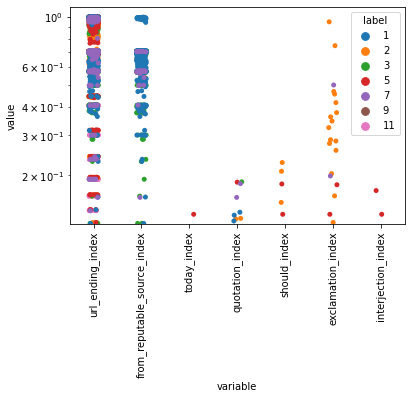

In [46]:
g = sns.stripplot(x='variable',
                  y='value',
                  hue='label',
                  data=pd.melt(d_subset_robust,
                               id_vars='label',
                               value_vars=d_subset_robust.columns.drop('label')))
g.set_xticklabels(d_subset_robust.columns, rotation=90)
g.set_yscale("log")